In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit import RDPaths
from functools import partial
from sklearn.metrics import roc_auc_score

import numpy as np
import random
import torch
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'
    
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import dgl
from  dgl.data.utils import split_dataset
from dgllife.model import model_zoo

from dgllife.utils import mol_to_complete_graph, mol_to_bigraph
from dgllife.utils import atom_type_one_hot
from dgllife.utils import atom_degree_one_hot
from dgllife.utils import atom_formal_charge
from dgllife.utils import atom_num_radical_electrons
from dgllife.utils import atom_hybridization_one_hot
from dgllife.utils import atom_total_num_H_one_hot
from dgllife.utils import one_hot_encoding
from dgllife.utils import CanonicalAtomFeaturizer
from dgllife.utils import CanonicalBondFeaturizer
from dgllife.utils import ConcatFeaturizer
from dgllife.utils import BaseAtomFeaturizer
from dgllife.utils import BaseBondFeaturizer
from dgllife.utils import one_hot_encoding

use GPU


/media/suhaib/intensobp/5-Python_envs/pythonvenv/dgl_venv/lib/python3.9/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
     
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))
 
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
     
    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks
 
 
def run_a_train_epoch(n_epochs, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
     
    for batch_id, batch_data in enumerate(data_loader):
        batch_data
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
         
        prediction = model(bg, bg.ndata['hv'], bg.edata['he'])
        loss = (loss_criterion(prediction, labels)*(masks != 0).float()).mean()
        #loss = loss_criterion(prediction, labels)
        #print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        losses.append(loss.data.item())
         
 
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format( epoch + 1, n_epochs,  total_score))
    return total_score

In [3]:
atom_featurizer = BaseAtomFeaturizer(
                 {'hv': ConcatFeaturizer([
                  partial(atom_type_one_hot, allowable_set=[
                          'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                    encode_unknown=True),
                  partial(atom_degree_one_hot, allowable_set=list(range(6))),
                  atom_formal_charge, atom_num_radical_electrons,
                  partial(atom_hybridization_one_hot, encode_unknown=True),
                  lambda atom: [0], # A placeholder for aromatic information,
                    atom_total_num_H_one_hot, chirality
                 ],
                )})
bond_featurizer = BaseBondFeaturizer({
                                     'he': lambda bond: [0 for _ in range(10)]
    })

In [49]:
import pandas as pd
train_csv = '../dataverse_solubility/AqSolDBc_smiles_solubility.csv'
test_csv = '../dataverse_solubility/OChemUnseen.csv'

# Load the training data into a Pandas DataFrame
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Ensure SMILEScurated is of string type and drop any rows with missing or invalid SMILES
train_df['SMILEScurated'] = train_df['SMILEScurated'].astype(str)
test_df['SMILES'] = test_df['SMILES'].astype(str)

# Function to filter and print invalid SMILES
def is_valid_smiles(smi, solubility):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Invalid SMILES: {smi}, Solubility: {solubility}")
        return False
    return True

# Apply the filter and print invalid SMILES for the training data
valid_train_df = train_df[train_df.apply(lambda row: is_valid_smiles(row['SMILEScurated'], row['Solubility']), axis=1)]

# Apply the filter and print invalid SMILES for the test data
valid_test_df = test_df[test_df.apply(lambda row: is_valid_smiles(row['SMILES'], row['LogS']), axis=1)]

# Extract SMILES strings and solubility values from the training data
train_smi = valid_train_df['SMILEScurated'].tolist()
train_sol = torch.tensor(valid_train_df['Solubility'].values).reshape(-1, 1)

# Extract SMILES strings and solubility values from the test data
test_smi = valid_test_df['SMILES'].tolist()
test_sol = torch.tensor(valid_test_df['LogS'].values).reshape(-1, 1)

# Convert solubility values to float32
train_sol = torch.tensor(valid_train_df['Solubility'].values, dtype=torch.float32).reshape(-1, 1)
test_sol = torch.tensor(valid_test_df['LogS'].values, dtype=torch.float32).reshape(-1, 1)

# Structures as RDkit Mols
train_mols = [Chem.MolFromSmiles(smi) for smi in train_smi]
test_mols = [Chem.MolFromSmiles(smi) for smi in test_smi]

# Structures as Graphs
train_graph =[mol_to_bigraph(mol,
                           node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in train_mols]
 
test_graph =[mol_to_bigraph(mol,
                           node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in test_mols]

train_loader = DataLoader(dataset=list(zip(train_smi, train_graph, train_sol)), batch_size=128, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=list(zip(test_smi, test_graph, test_sol)), batch_size=128, collate_fn=collate_molgraphs)

Invalid SMILES: nan, Solubility: -7.89163614
Invalid SMILES: nan, Solubility: -8.217167979
Invalid SMILES: nan, Solubility: -8.213807356
Invalid SMILES: nan, Solubility: -7.461800322
Invalid SMILES: nan, Solubility: -7.62669423
Invalid SMILES: nan, Solubility: -8.479083332
Invalid SMILES: nan, Solubility: 0.9621
Invalid SMILES: nan, Solubility: -1.2983


In [14]:
model = model_zoo.attentivefp_predictor.AttentiveFPPredictor(node_feat_size=39,
                                  edge_feat_size=10,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=200,
                                  dropout=0.2)
model = model.to('cuda:0')

In [20]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0),)
n_epochs = 1000
epochs = []
scores = []

# Ensure graph and target are on the same device
def run_a_train_epoch(n_epochs, epoch, model, data_loader, loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
     
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        
        # Move batch graph (bg) and labels/masks to the GPU if available
        if torch.cuda.is_available():
            bg = bg.to(torch.device('cuda:0'))
            labels = labels.to(torch.device('cuda:0'))
            masks = masks.to(torch.device('cuda:0'))

        # Extract node and edge features, ensuring they are on the correct device
        node_feats = bg.ndata['hv'].to(torch.device('cuda:0'))
        edge_feats = bg.edata['he'].to(torch.device('cuda:0'))
        
        # Forward pass
        prediction = model(bg, node_feats, edge_feats)
        
        # Compute loss
        loss = (loss_criterion(prediction, labels) * (masks != 0).float()).mean()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        # Track loss
        losses.append(loss.item())
         
    total_score = np.mean(losses)
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {total_score:.4f}')
    return total_score
    

# Training Loop
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)
model.eval()

Epoch 1/1000, Training Loss: 1.3449
Epoch 2/1000, Training Loss: 1.2465
Epoch 3/1000, Training Loss: 1.2663
Epoch 4/1000, Training Loss: 1.2354
Epoch 5/1000, Training Loss: 1.1987
Epoch 6/1000, Training Loss: 1.3033
Epoch 7/1000, Training Loss: 1.2833
Epoch 8/1000, Training Loss: 1.2952
Epoch 9/1000, Training Loss: 1.2489
Epoch 10/1000, Training Loss: 1.2188
Epoch 11/1000, Training Loss: 1.2293
Epoch 12/1000, Training Loss: 1.1940
Epoch 13/1000, Training Loss: 1.1907
Epoch 14/1000, Training Loss: 1.1884
Epoch 15/1000, Training Loss: 1.2206
Epoch 16/1000, Training Loss: 1.2193
Epoch 17/1000, Training Loss: 1.1991
Epoch 18/1000, Training Loss: 1.2030
Epoch 19/1000, Training Loss: 1.1920
Epoch 20/1000, Training Loss: 1.1915
Epoch 21/1000, Training Loss: 1.1863
Epoch 22/1000, Training Loss: 1.1861
Epoch 23/1000, Training Loss: 1.1617
Epoch 24/1000, Training Loss: 1.1832
Epoch 25/1000, Training Loss: 1.1763
Epoch 26/1000, Training Loss: 1.2273
Epoch 27/1000, Training Loss: 1.1422
Epoch 28/1

AttentiveFPPredictor(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=200, out_features=200, bias=True)
        )
        (gru): GRUCell(200, 200)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=400, out_fea

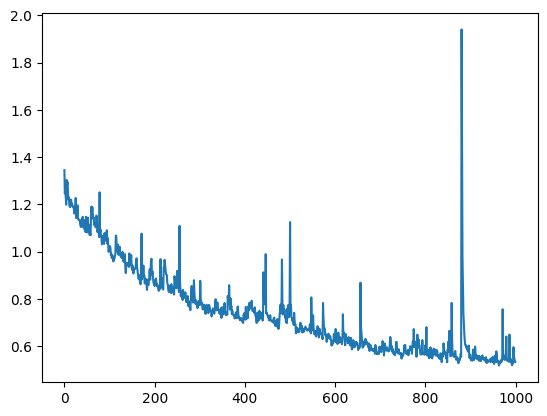

In [21]:
plt.plot(epochs, scores)

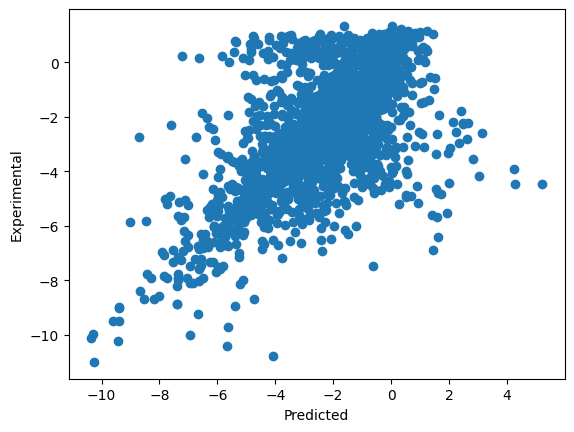

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Plot the training loss (or scores)
plt.plot(epochs, scores)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store all predictions
all_pred = []

# Loop through the test data
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    
    # Move everything to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    bg = bg.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    
    # Get node and edge features and move them to the correct device
    node_feats = bg.ndata['hv'].to(device)
    edge_feats = bg.edata['he'].to(device)
    
    # Perform the prediction
    pred = model(bg, node_feats, edge_feats)
    
    # Store the predictions on the CPU
    all_pred.append(pred.data.cpu().numpy())

# Convert the predictions to a numpy array
res = np.vstack(all_pred)

# Plot the results
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('Predicted')
plt.ylabel('Experimental')
plt.show()

0.279232919216156


/media/suhaib/intensobp/5-Python_envs/pythonvenv/dgl_venv/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


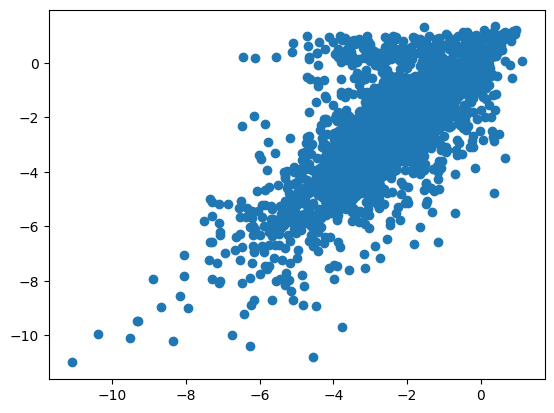

In [23]:
from sklearn.metrics import r2_score
print(r2_score(test_sol, res))

from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import AllChem
train_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in train_mols]
test_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in test_mols]
# make RF regressor and train it.
rfr = RandomForestRegressor()
rfr.fit(train_fp, train_sol)

rfr_pred = rfr.predict(test_fp)
r2_score(test_sol, rfr_pred)
plt.clf()
plt.scatter(rfr_pred, test_sol)

In [25]:
# Specify the file path to save the model state
save_path = 'AqSolDB_AttFPPmodel_checkpoint_1000e.pth'

# Save the model state, optimizer state, and current epoch
torch.save({
    'epoch': n_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': scores[-1]  # Save the last loss for reference
}, save_path)

print(f"Model saved after {n_epochs} epochs.")

Model saved after 1000 epochs.


In [27]:
# Specify the file path where the model was saved
load_path = 'AqSolDB_AttFPPmodel_checkpoint_1000e.pth'

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state, optimizer state, and the last completed epoch
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

print(f"Resuming training from epoch {start_epoch + 1}")

Resuming training from epoch 1001


In [28]:
# Set the number of additional epochs to train
additional_epochs = 1000

save_path = 'AqSolDB_AttFPPmodel_checkpoint_2000e.pth'

# Continue training from the saved epoch
for e in range(start_epoch, start_epoch + additional_epochs):
    score = run_a_train_epoch(start_epoch + additional_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)

# Save the model again after additional training if needed
torch.save({
    'epoch': start_epoch + additional_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': scores[-1]
}, save_path)

print(f"Model saved after additional {additional_epochs} epochs.")

Epoch 1001/2000, Training Loss: 0.5428
Epoch 1002/2000, Training Loss: 0.5542
Epoch 1003/2000, Training Loss: 0.5398
Epoch 1004/2000, Training Loss: 0.5355
Epoch 1005/2000, Training Loss: 0.5460
Epoch 1006/2000, Training Loss: 0.5444
Epoch 1007/2000, Training Loss: 0.5419
Epoch 1008/2000, Training Loss: 0.5293
Epoch 1009/2000, Training Loss: 0.5378
Epoch 1010/2000, Training Loss: 0.5287
Epoch 1011/2000, Training Loss: 0.5641
Epoch 1012/2000, Training Loss: 0.5454
Epoch 1013/2000, Training Loss: 0.5356
Epoch 1014/2000, Training Loss: 0.5209
Epoch 1015/2000, Training Loss: 0.5301
Epoch 1016/2000, Training Loss: 0.5240
Epoch 1017/2000, Training Loss: 0.5170
Epoch 1018/2000, Training Loss: 0.5333
Epoch 1019/2000, Training Loss: 0.5193
Epoch 1020/2000, Training Loss: 0.5249
Epoch 1021/2000, Training Loss: 0.5269
Epoch 1022/2000, Training Loss: 0.5476
Epoch 1023/2000, Training Loss: 0.5517
Epoch 1024/2000, Training Loss: 0.5451
Epoch 1025/2000, Training Loss: 0.5275
Epoch 1026/2000, Training

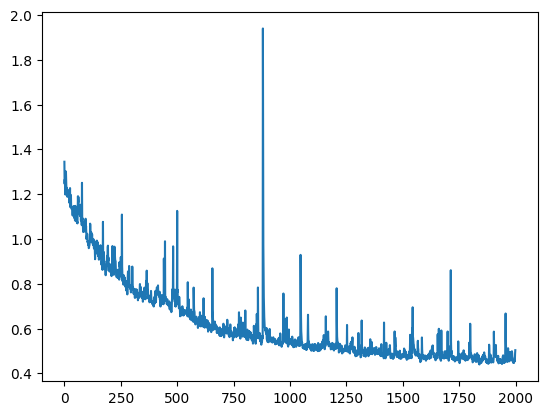

In [29]:
plt.plot(epochs, scores)

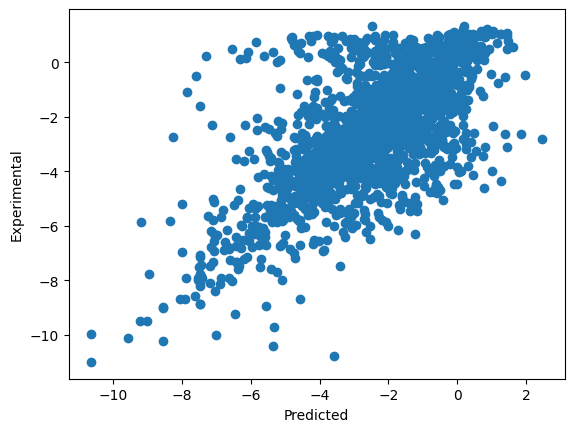

In [30]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store all predictions
all_pred = []

# Loop through the test data
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    
    # Move everything to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    bg = bg.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    
    # Get node and edge features and move them to the correct device
    node_feats = bg.ndata['hv'].to(device)
    edge_feats = bg.edata['he'].to(device)
    
    # Perform the prediction
    pred = model(bg, node_feats, edge_feats)
    
    # Store the predictions on the CPU
    all_pred.append(pred.data.cpu().numpy())

# Convert the predictions to a numpy array
res = np.vstack(all_pred)

# Plot the results
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('Predicted')
plt.ylabel('Experimental')
plt.show()

In [32]:
# Specify the file path where the model was saved
load_path = 'AqSolDB_AttFPPmodel_checkpoint_2000e.pth'

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state, optimizer state, and the last completed epoch
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

print(f"Resuming training from epoch {start_epoch + 1}")

Resuming training from epoch 2001


In [33]:
# Set the number of additional epochs to train
additional_epochs = 1000

save_path = 'AqSolDB_AttFPPmodel_checkpoint_3000e.pth'

# Continue training from the saved epoch
for e in range(start_epoch, start_epoch + additional_epochs):
    score = run_a_train_epoch(start_epoch + additional_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)

# Save the model again after additional training if needed
torch.save({
    'epoch': start_epoch + additional_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': scores[-1]
}, save_path)

print(f"Model saved after additional {additional_epochs} epochs.")

Epoch 2001/3000, Training Loss: 0.4618
Epoch 2002/3000, Training Loss: 0.4682
Epoch 2003/3000, Training Loss: 0.4510
Epoch 2004/3000, Training Loss: 0.4641
Epoch 2005/3000, Training Loss: 0.4560
Epoch 2006/3000, Training Loss: 0.4574
Epoch 2007/3000, Training Loss: 0.5663
Epoch 2008/3000, Training Loss: 0.4825
Epoch 2009/3000, Training Loss: 0.4727
Epoch 2010/3000, Training Loss: 0.4552
Epoch 2011/3000, Training Loss: 0.4506
Epoch 2012/3000, Training Loss: 0.4540
Epoch 2013/3000, Training Loss: 0.5040
Epoch 2014/3000, Training Loss: 0.4565
Epoch 2015/3000, Training Loss: 0.4569
Epoch 2016/3000, Training Loss: 0.5273
Epoch 2017/3000, Training Loss: 0.4697
Epoch 2018/3000, Training Loss: 0.4646
Epoch 2019/3000, Training Loss: 0.4679
Epoch 2020/3000, Training Loss: 0.4646
Epoch 2021/3000, Training Loss: 0.4565
Epoch 2022/3000, Training Loss: 0.4576
Epoch 2023/3000, Training Loss: 0.4580
Epoch 2024/3000, Training Loss: 0.4564
Epoch 2025/3000, Training Loss: 0.4472
Epoch 2026/3000, Training

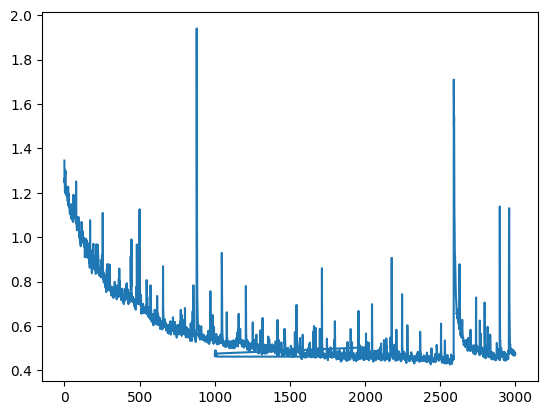

In [35]:
model.eval()
plt.plot(epochs, scores)

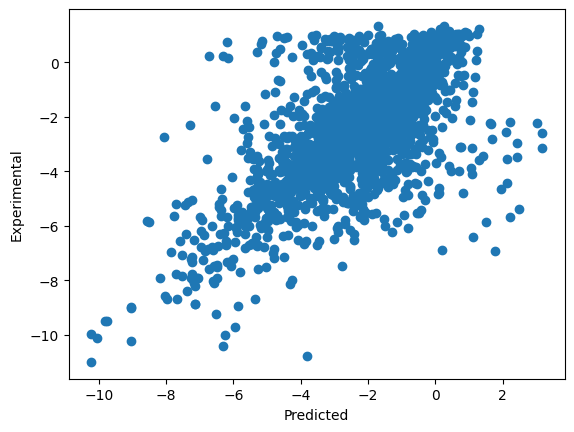

In [50]:
# Initialize a list to store all predictions
all_pred = []

# Loop through the test data
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    
    # Move everything to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    bg = bg.to(device)
    labels = labels.to(device)
    masks = masks.to(device)
    
    # Get node and edge features and move them to the correct device
    node_feats = bg.ndata['hv'].to(device)
    edge_feats = bg.edata['he'].to(device)
    
    # Perform the prediction
    pred = model(bg, node_feats, edge_feats)
    
    # Store the predictions on the CPU
    all_pred.append(pred.data.cpu().numpy())

# Convert the predictions to a numpy array
res = np.vstack(all_pred)

# Plot the results
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('Predicted')
plt.ylabel('Experimental')
plt.show()

In [70]:
# Assuming res and test_sol are NumPy arrays
res_flat = res.flatten()
test_sol_flat = test_sol.flatten()

# Convert flattened arrays to lists
res_list = res_flat.tolist()
test_sol_list = test_sol_flat.tolist()

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Sample data (replace these with your actual predictions and SMILES)
# Example definitions

#res = np.array([0.5, 0.6, 0.7, 0.8, 0.9])  # Replace with your predicted values
#sol = np.array([0.55, 0.65, 0.75, 0.85, 0.95])  # Replace with your actual values
#smi = ["C1CCCC1", "C1=CC=CC=C1", "CCO", "CCN", "CNC"]  # Replace with your SMILES strings

# Assuming `res_list` (predictions), `test_sol_list` (actual values), and `test_smi` (SMILES strings) are PyTorch tensors
# Convert lists to NumPy arrays
res_array = np.array(res_list).reshape(-1, 1)  # Reshape to (n_samples, 1)
test_sol_array = np.array(test_sol_list).reshape(-1, 1)  # Reshape to (n_samples, 1)

# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(res_array, test_sol_array)

# Get the trend line
trend_line = lin_reg.predict(res_array)

# Calculate the residuals
residuals = test_sol_array - trend_line

# Flatten arrays for std calculation
residuals_flat = residuals.flatten()

Outlier SMILES strings and their corresponding actual and predicted values:
SMILES: O=C([O-])C(=O)[O-], Actual: 0.3799999952316284, Predicted: -1.8076763153076172
SMILES: CC1CC2C3CCC4=CC(=O)C=CC4(C)C3=CCC2(C)C1C(=O)CN1CCN(c2cc(N3CCCC3)nc(N3CCCC3)n2)CC1, Actual: -7.590000152587891, Predicted: -5.273151397705078
SMILES: CC1(C)C(C=C(Cl)Cl)C1C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1, Actual: -8.017000198364258, Predicted: -6.593557357788086
SMILES: O=C(Cc1cccs1)NC1C(=O)N2C(C(=O)[O-])=C(C[n+]3ccccc3)CSC12, Actual: 1.3200000524520874, Predicted: -1.697324514389038
SMILES: Brc1ccc(Oc2ccc(Br)c(Br)c2)cc1Br, Actual: -7.909999847412109, Predicted: -6.487215995788574
SMILES: Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)cc1Br, Actual: -8.869999885559082, Predicted: -7.139585971832275
SMILES: Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)c(Br)c1, Actual: -8.869999885559082, Predicted: -7.139118671417236
SMILES: Cc1cc(O)ccc1O[P+](O)(Oc1cc(O)ccc1C)Oc1c(C)cccc1O, Actual: -6.699999809265137, Predicted: -3.5106303691864014
SMILES: Cc1ccc(O[

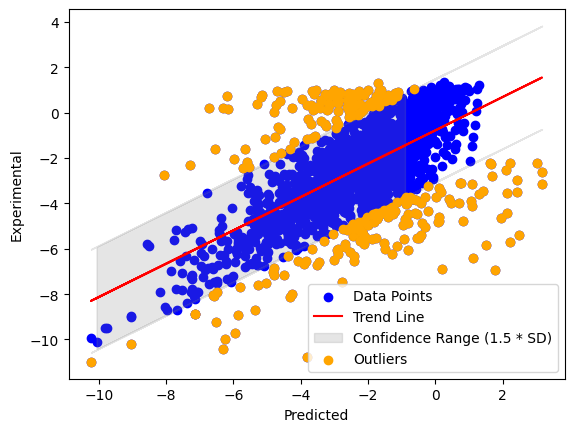

In [75]:
# Calculate the standard deviation of the residuals
std_residuals = np.std(residuals)

# Calculate the confidence range (1.5 * SD)
confidence_range = 1.5 * std_residuals

# Identify points outside the confidence range
lower_bound = trend_line - confidence_range
upper_bound = trend_line + confidence_range

# Find indices of points outside the confidence range
outliers = (test_sol_array < lower_bound) | (test_sol_array > upper_bound)
outlier_indices = np.where(outliers.flatten())[0]

# Trace back to the SMILES strings
outlier_smiles = [test_smi[i] for i in outlier_indices]

# Print or store the outliers
print(f"Outlier SMILES strings and their corresponding actual and predicted values:")
for idx in outlier_indices:
    print(f"SMILES: {test_smi[idx]}, Actual: {test_sol[idx][0]}, Predicted: {res[idx][0]}")

# Optional: Save the outlier details to a CSV file
outliers_df = pd.DataFrame({
    'SMILES': [test_smi[i] for i in outlier_indices],
    'Actual': [test_sol[i][0] for i in outlier_indices],
    'Predicted': [res[i][0] for i in outlier_indices],
    'Residual': [test_sol[i][0] - trend_line[i][0] for i in outlier_indices]
})

outliers_df.to_csv('outliers.csv', index=False)
print("Outliers have been saved to 'outliers.csv'.")

# Plot the results
plt.clf()
plt.scatter(res, test_sol, label='Data Points', color='blue')

# Plot the trend line
plt.plot(res, trend_line, color='red', label='Trend Line')

# Plot the confidence range
plt.fill_between(res.flatten(), 
                 (trend_line.flatten() - confidence_range).flatten(), 
                 (trend_line.flatten() + confidence_range).flatten(), 
                 color='gray', alpha=0.2, label='Confidence Range (1.5 * SD)')

# Highlight outliers
plt.scatter(np.array(res)[outlier_indices], np.array(test_sol)[outlier_indices], 
            color='orange', label='Outliers')

# Label the axes
plt.xlabel('Predicted')
plt.ylabel('Experimental')
plt.legend()
plt.show()